### In this Notebook I'm going to use PyTorch TabNet

In [ ]:
!pip install pytorch-tabnet

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

import optuna

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import os

In [2]:
BASE_DIR = './data-tab-march'

FILE_TRAIN = BASE_DIR + '/train.csv'
FILE_TEST = BASE_DIR + '/test.csv'

In [3]:
orig_data = pd.read_csv(FILE_TRAIN)

In [4]:
orig_data.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [5]:
# GLOBALS
FOLDS = 5
PREDICTOR = 'target'

# feature not used
unused_feat = ['id', 'cat10']

In [6]:
# before any transformation, make a copy
data = orig_data.copy()

In [7]:
# columns that will be used
num_col_list = [ 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
                'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

cat_col_list = ['cat0', 'cat1', 'cat2','cat3','cat4','cat5','cat6',
                'cat7','cat8', 'cat9',
                'cat11', 'cat12','cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']

all_col_list = num_col_list + cat_col_list

In [8]:
# encode cat features (with label encoder)
nunique = data.nunique()
types = data.dtypes

categorical_columns = cat_col_list
categorical_dims =  {}

# I need to save the encoder list for the processing of the test set
enc_list = []

print('Col-name, distinct-values')
for col in cat_col_list:
    print(col, data[col].nunique())
    l_enc = LabelEncoder()
    data[col] = l_enc.fit_transform(data[col].values)
    
    # save the encoder for the test set
    enc_list.append(l_enc)
    categorical_dims[col] = len(l_enc.classes_)

Col-name, distinct-values
cat0 2
cat1 15
cat2 19
cat3 13
cat4 20
cat5 84
cat6 16
cat7 51
cat8 61
cat9 19
cat11 2
cat12 2
cat13 2
cat14 2
cat15 4
cat16 4
cat17 4
cat18 4


In [9]:
# split data in train, validation
FRAC = 0.9

N_TRAIN = int(data.shape[0] * FRAC)
N_VALID = data.shape[0] - N_TRAIN

# before splitting, shuffle
data = data.sample(frac = 1)

df_train = data[:N_TRAIN]
df_valid = data[N_TRAIN:]

print('Number of records in train dataset:', N_TRAIN)
print('Number of records in validation dataset:', N_VALID)

Number of records in train dataset: 270000
Number of records in validation dataset: 30000


In [10]:
label_train = df_train[PREDICTOR].values
label_valid = df_valid[PREDICTOR].values

df_train = df_train[all_col_list]
df_valid = df_valid[all_col_list]

In [11]:
features = [ col for col in df_train.columns if col not in unused_feat+[PREDICTOR]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [12]:
df_train.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat8,cat9,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18
273032,0.719805,0.561335,0.716844,0.559031,0.716309,0.735489,0.596555,0.606377,0.691290,0.521496,...,60,4,0,1,0,0,1,3,3,1
233798,0.718063,0.647437,0.481471,0.664019,0.621247,0.357092,0.415081,0.710790,0.376146,0.322956,...,51,0,0,0,0,0,3,3,3,1
187188,0.306894,0.920827,0.911301,0.307251,0.212348,0.802878,0.865215,0.462879,0.966667,0.573785,...,19,0,0,0,0,1,3,1,3,2
218268,0.560873,0.601003,0.754977,0.594548,0.673171,0.488206,0.344683,0.843957,0.655516,0.525252,...,50,0,0,0,0,0,1,3,3,1
211377,0.341032,0.546334,0.313081,0.050961,0.261937,0.756360,0.326802,0.335715,0.400114,0.623238,...,48,0,1,0,0,1,3,1,1,3


In [13]:
# fit parameters
EPOCHS = 5
BATCH_SIZE = 4096

In [14]:
def objective(trial):
    # parameter set by optuna
    N_D = trial.suggest_int('N_D', 8, 32)
    N_A = N_D
    GAMMA = trial.suggest_float('GAMMA', 1.0, 2.0)
    N_STEPS = trial.suggest_int('N_STEPS', 2, 10)
    
    clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax',
                          n_d = N_D,
                          n_a = N_A,
                          gamma = GAMMA,
                          n_steps = N_STEPS)
    
    clf.fit(df_train.values, label_train,
        eval_set=[(df_train.values, label_train),(df_valid.values, label_valid)],
        max_epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        patience = 5,
        eval_name=['train', 'valid'],
        eval_metric=['auc']
           )
    
    score = clf.history['valid_auc'][-1]
    
    return score

In [15]:
study = optuna.create_study(direction='maximize', study_name = 'tabnet-study1')

study.optimize(objective, n_trials=10, timeout = 3600)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-03-08 15:07:56,218] A new study created in memory with name: tabnet-study1


Device used : cpu
epoch 0  | loss: 0.53386 | train_auc: 0.84452 | valid_auc: 0.84785 |  0:01:15s
epoch 1  | loss: 0.39068 | train_auc: 0.85915 | valid_auc: 0.86079 |  0:02:18s
epoch 2  | loss: 0.38569 | train_auc: 0.86456 | valid_auc: 0.86543 |  0:03:21s
epoch 3  | loss: 0.38161 | train_auc: 0.86967 | valid_auc: 0.87002 |  0:04:30s
epoch 4  | loss: 0.37814 | train_auc: 0.87327 | valid_auc: 0.87327 |  0:05:53s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.87327
Best weights from best epoch are automatically used!


[I 2021-03-08 15:14:00,762] Trial 0 finished with value: 0.8732670698091182 and parameters: {'N_D': 12, 'GAMMA': 1.189689568820747, 'N_STEPS': 4}. Best is trial 0 with value: 0.8732670698091182.


Device used : cpu
epoch 0  | loss: 0.47805 | train_auc: 0.84298 | valid_auc: 0.84485 |  0:02:22s
epoch 1  | loss: 0.39294 | train_auc: 0.85889 | valid_auc: 0.86064 |  0:04:32s
epoch 2  | loss: 0.38508 | train_auc: 0.86079 | valid_auc: 0.86251 |  0:06:29s
epoch 3  | loss: 0.38055 | train_auc: 0.86726 | valid_auc: 0.86791 |  0:08:24s
epoch 4  | loss: 0.37733 | train_auc: 0.87181 | valid_auc: 0.87206 |  0:10:33s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.87206
Best weights from best epoch are automatically used!


[I 2021-03-08 15:24:56,410] Trial 1 finished with value: 0.8720575170544191 and parameters: {'N_D': 30, 'GAMMA': 1.388160173469322, 'N_STEPS': 4}. Best is trial 0 with value: 0.8732670698091182.


Device used : cpu
epoch 0  | loss: 0.56325 | train_auc: 0.82303 | valid_auc: 0.8239  |  0:02:46s
epoch 1  | loss: 0.41898 | train_auc: 0.83254 | valid_auc: 0.83331 |  0:05:34s
epoch 2  | loss: 0.41208 | train_auc: 0.83986 | valid_auc: 0.84019 |  0:08:13s
epoch 3  | loss: 0.40952 | train_auc: 0.84239 | valid_auc: 0.84542 |  0:11:31s
epoch 4  | loss: 0.40701 | train_auc: 0.85011 | valid_auc: 0.85063 |  0:15:21s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.85063
Best weights from best epoch are automatically used!


[I 2021-03-08 15:40:44,384] Trial 2 finished with value: 0.8506282946036898 and parameters: {'N_D': 19, 'GAMMA': 1.307934393723742, 'N_STEPS': 8}. Best is trial 0 with value: 0.8732670698091182.


Device used : cpu
epoch 0  | loss: 0.55836 | train_auc: 0.83067 | valid_auc: 0.83239 |  0:02:35s
epoch 1  | loss: 0.41422 | train_auc: 0.84937 | valid_auc: 0.85193 |  0:05:10s
epoch 2  | loss: 0.403   | train_auc: 0.85096 | valid_auc: 0.85379 |  0:08:01s
epoch 3  | loss: 0.39896 | train_auc: 0.85556 | valid_auc: 0.85635 |  0:10:47s
epoch 4  | loss: 0.39826 | train_auc: 0.8542  | valid_auc: 0.8575  |  0:13:29s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.8575
Best weights from best epoch are automatically used!


[I 2021-03-08 15:54:35,169] Trial 3 finished with value: 0.8574955226449854 and parameters: {'N_D': 22, 'GAMMA': 1.3191006893124024, 'N_STEPS': 8}. Best is trial 0 with value: 0.8732670698091182.


Device used : cpu
epoch 0  | loss: 0.52067 | train_auc: 0.84746 | valid_auc: 0.84939 |  0:01:43s
epoch 1  | loss: 0.38824 | train_auc: 0.86073 | valid_auc: 0.86243 |  0:03:37s
epoch 2  | loss: 0.38259 | train_auc: 0.86501 | valid_auc: 0.8667  |  0:05:15s
epoch 3  | loss: 0.37959 | train_auc: 0.87044 | valid_auc: 0.8718  |  0:06:53s
epoch 4  | loss: 0.37732 | train_auc: 0.87298 | valid_auc: 0.87423 |  0:08:30s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.87423
Best weights from best epoch are automatically used!


[I 2021-03-08 16:03:21,344] Trial 4 finished with value: 0.8742325938905052 and parameters: {'N_D': 12, 'GAMMA': 1.0136605890386532, 'N_STEPS': 8}. Best is trial 4 with value: 0.8742325938905052.


Device used : cpu
epoch 0  | loss: 0.51471 | train_auc: 0.81197 | valid_auc: 0.81251 |  0:03:58s
epoch 1  | loss: 0.4131  | train_auc: 0.8415  | valid_auc: 0.8442  |  0:07:51s
epoch 2  | loss: 0.40678 | train_auc: 0.84872 | valid_auc: 0.8518  |  0:11:22s
epoch 3  | loss: 0.40362 | train_auc: 0.85504 | valid_auc: 0.85788 |  0:14:46s
epoch 4  | loss: 0.39906 | train_auc: 0.85604 | valid_auc: 0.85619 |  0:18:13s
Stop training because you reached max_epochs = 5 with best_epoch = 3 and best_valid_auc = 0.85788
Best weights from best epoch are automatically used!


[I 2021-03-08 16:22:00,504] Trial 5 finished with value: 0.8561936611369005 and parameters: {'N_D': 31, 'GAMMA': 1.3805691917660519, 'N_STEPS': 8}. Best is trial 4 with value: 0.8742325938905052.


Number of finished trials: 6
Best trial: {'N_D': 12, 'GAMMA': 1.0136605890386532, 'N_STEPS': 8}


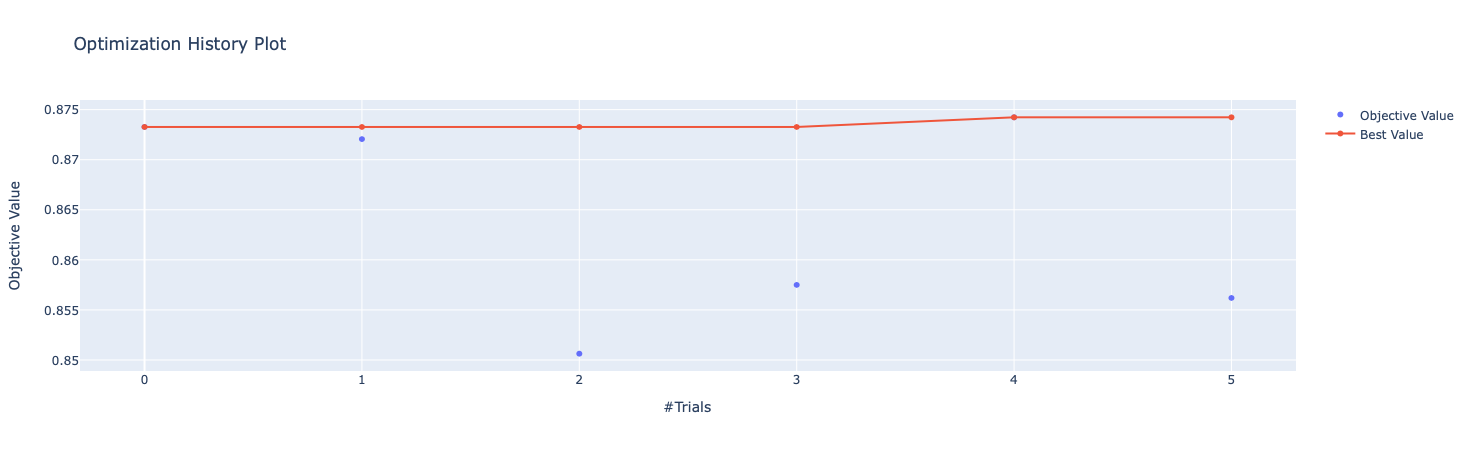

In [18]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

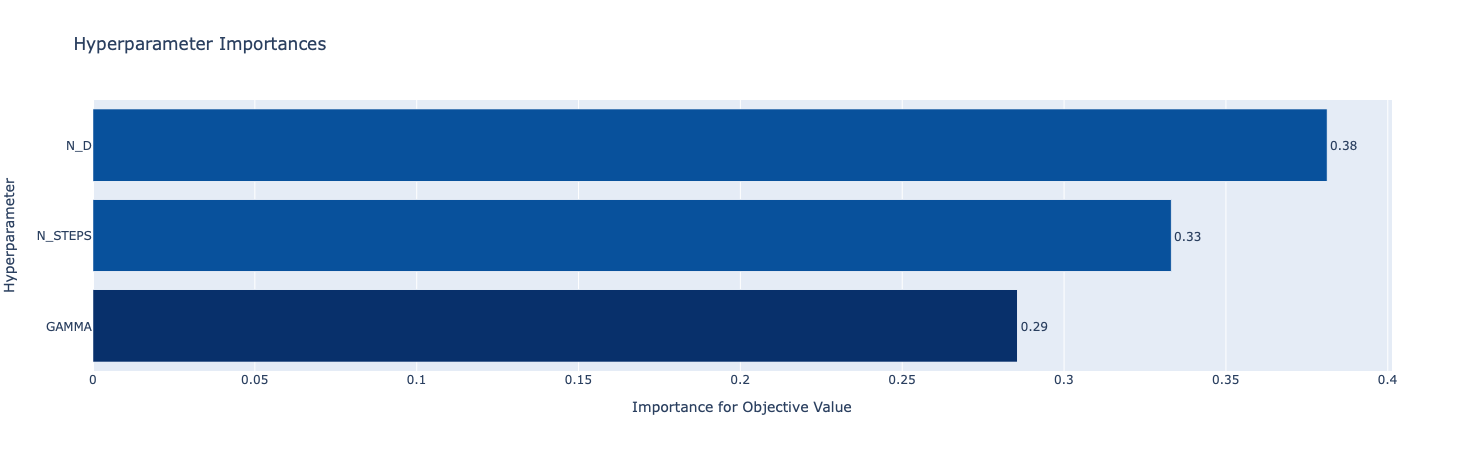

In [17]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

### Predictions on test Set